# Student Performance Prediction

## Project Overview
This project aims to predict students' exam scores based on various factors such as study hours, attendance, and other features from the **StudentPerformanceFactors.csv** dataset. The workflow includes:
- Data loading and exploration
- Data cleaning and preprocessing
- Training a linear regression model
- Evaluating model performance
- Exploring advanced techniques like polynomial regression and feature engineering

## Objectives
- Perform data cleaning and handle missing values/outliers
- Visualize data to understand feature distributions and relationships
- Train and evaluate a linear regression model
- Experiment with polynomial regression and feature engineering for performance improvement

## Tools and Libraries
- **Python**: Core programming language
- **Pandas**: Data manipulation and analysis
- **Matplotlib/Seaborn**: Data visualization
- **Scikit-learn**: Machine learning and preprocessing
- **Statsmodels**: Statistical analysis (VIF for multicollinearity)

## Dataset
- Source: [Student Performance Factors (Kaggle)](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset)
- Target Variable: `Exam_Score`
- Features: Study hours, attendance, parental education, teacher quality, etc.


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import SelectKBest, f_regression

import os 
import joblib




## 1. Data Loading and Initial Exploration

We load the dataset using a custom `DataLoader` class and perform initial exploration to understand its structure, missing values, and basic statistics.


In [3]:
# Define the path to the dataset
DATA_PATH = './data/raw_data/StudentPerformanceFactors.csv'

# Load the dataset
df = pd.read_csv(DATA_PATH)

# Display the first few rows
print("First 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [4]:
# Display dataset information
print("Dataset Info:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 n

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [5]:
# Check for missing values
print("\n🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")

# Check for duplicate rows
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"Dropped {df.duplicated().sum()} duplicate rows")
else:
    print("No duplicate rows found")



🔍 Missing Values:
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64
No duplicate rows found


## 2. Exploratory Data Analysis (EDA)

We explore the dataset to understand feature distributions, detect outliers, and analyze categorical variables.


In [6]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

print(f"Numeric Columns: {numeric_cols.tolist()}")
print(f"Categorical Columns: {categorical_cols.tolist()}")


Numeric Columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']
Categorical Columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


Number of rows with outliers: 553


C:\Users\mkrym\AppData\Local\Temp\ipykernel_18352\3343845921.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[col] for col in numeric_cols], labels=numeric_cols)


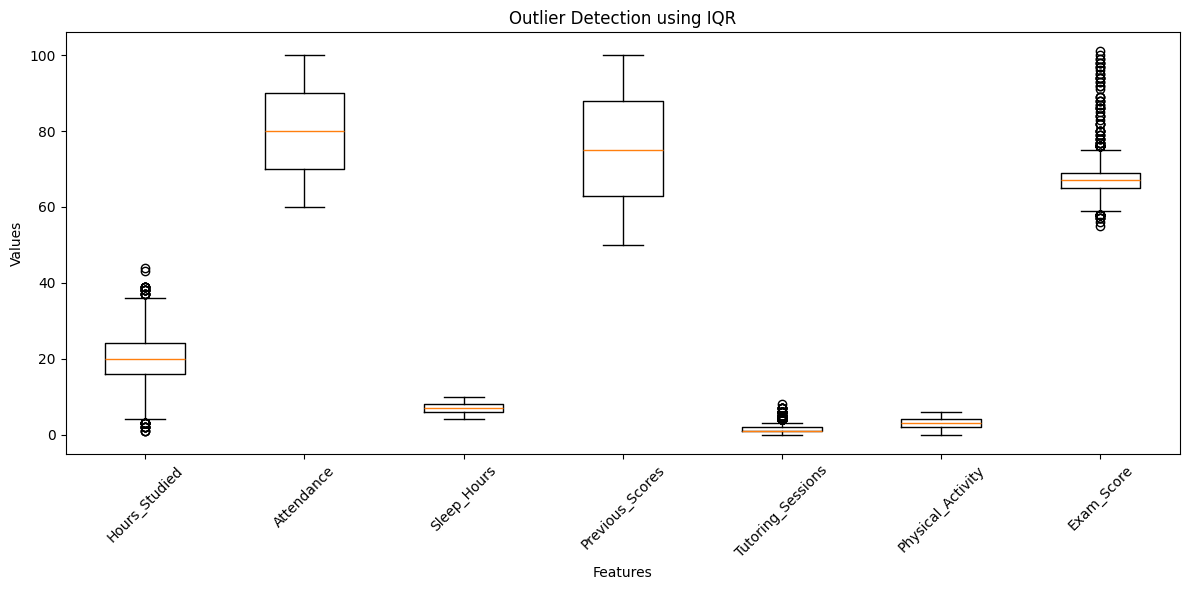

In [7]:
# Outlier detection using IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows with outliers
outliers = df[((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]
print(f"Number of rows with outliers: {outliers.shape[0]}")

# Visualize outliers with boxplots
plt.figure(figsize=(12, 6))
plt.boxplot([df[col] for col in numeric_cols], labels=numeric_cols)
plt.title("Outlier Detection using IQR")
plt.xlabel("Features")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



🔍 Categorical Feature Value Counts:

▶ Parental_Involvement:
Parental_Involvement
Medium    3362
High      1908
Low       1337
Name: count, dtype: int64

▶ Access_to_Resources:
Access_to_Resources
Medium    3319
High      1975
Low       1313
Name: count, dtype: int64

▶ Extracurricular_Activities:
Extracurricular_Activities
Yes    3938
No     2669
Name: count, dtype: int64

▶ Motivation_Level:
Motivation_Level
Medium    3351
Low       1937
High      1319
Name: count, dtype: int64

▶ Internet_Access:
Internet_Access
Yes    6108
No      499
Name: count, dtype: int64

▶ Family_Income:
Family_Income
Low       2672
Medium    2666
High      1269
Name: count, dtype: int64

▶ Teacher_Quality:
Teacher_Quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64

▶ School_Type:
School_Type
Public     4598
Private    2009
Name: count, dtype: int64

▶ Peer_Influence:
Peer_Influence
Positive    2638
Neutral     2592
Negative    1377
Name: count, dtype: int64

▶ Learning_Disabilit

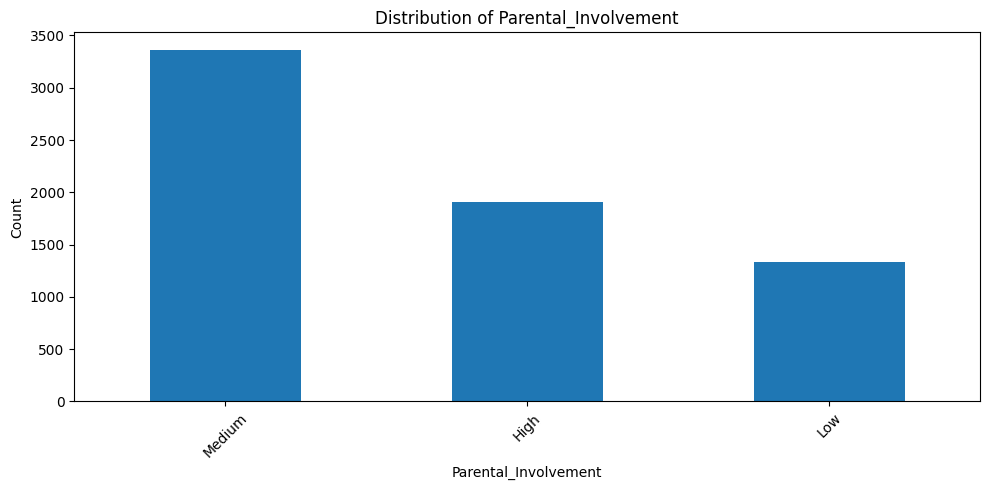

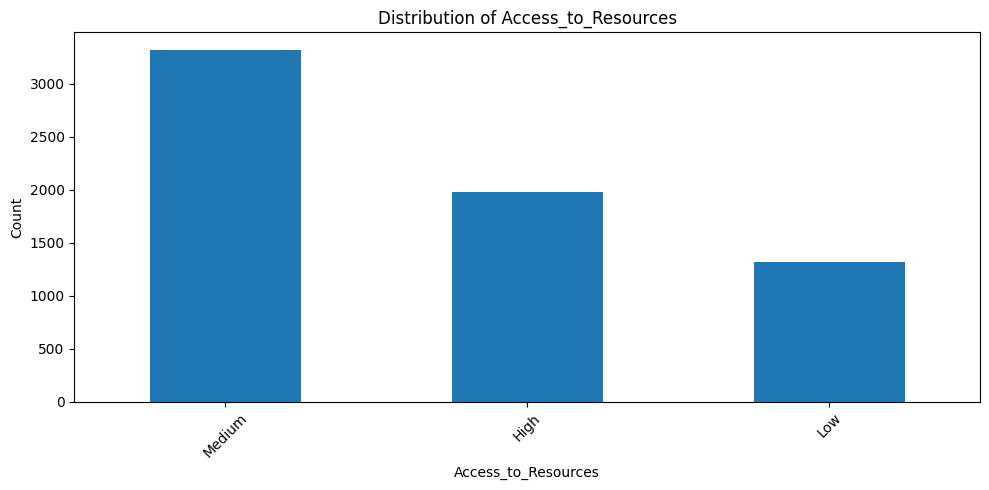

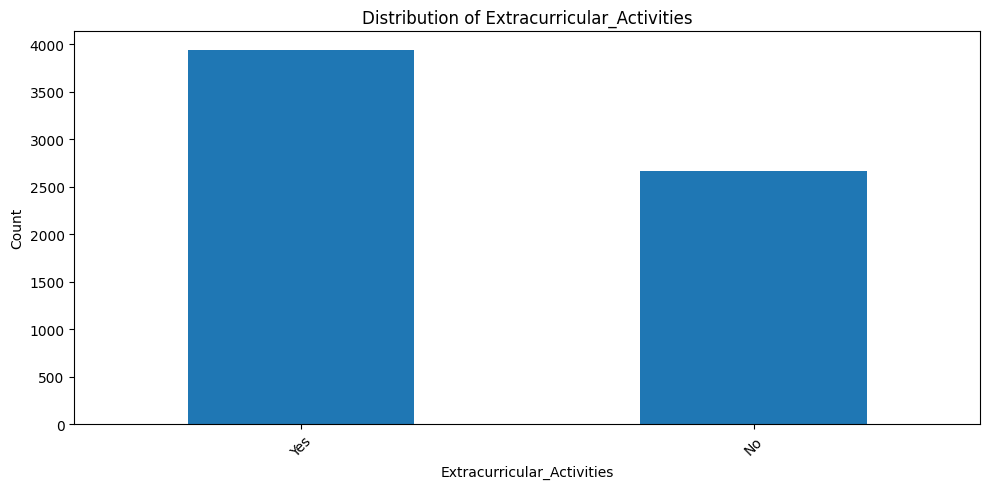

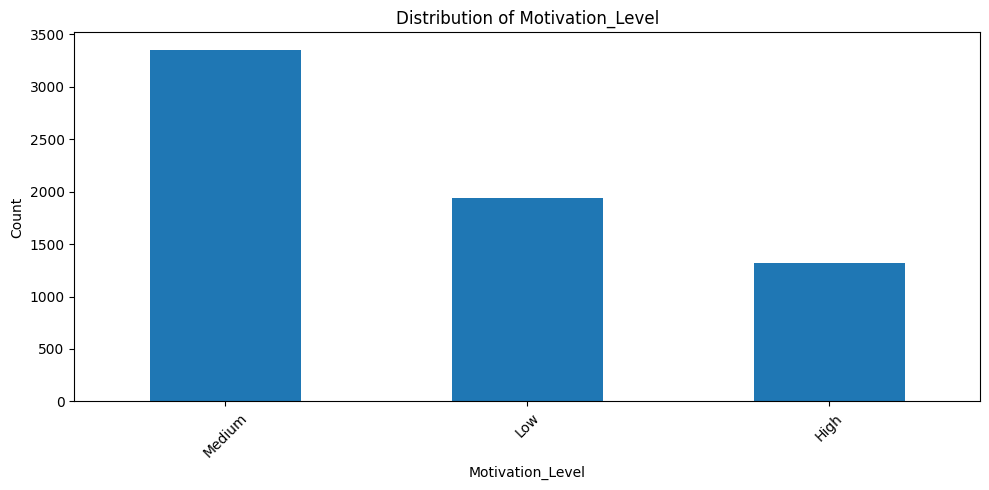

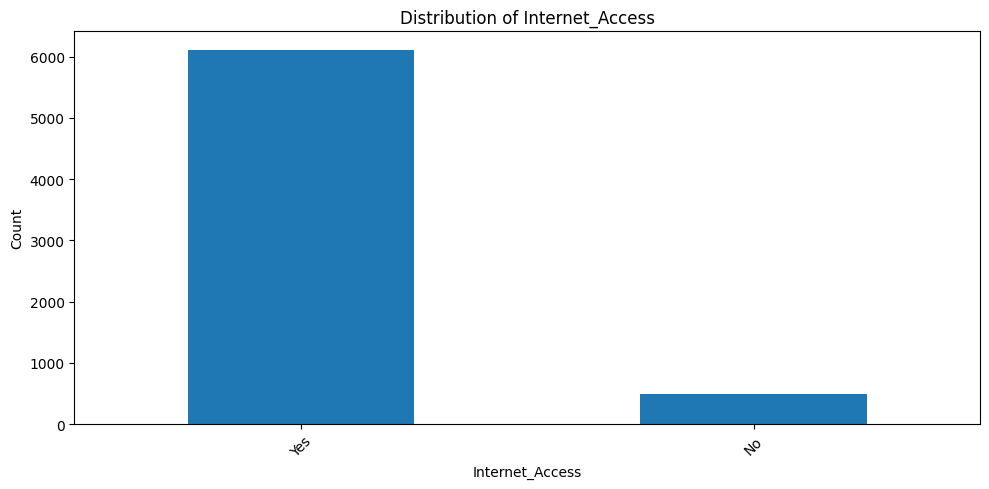

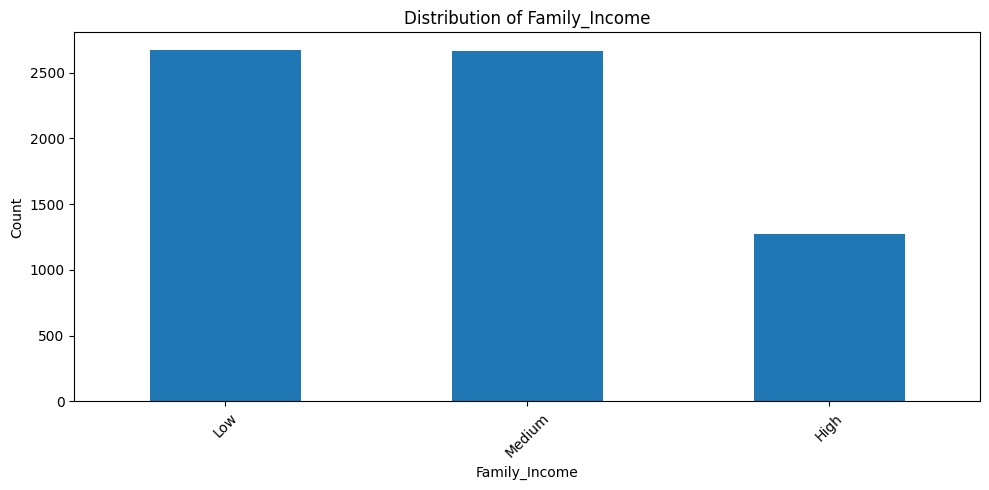

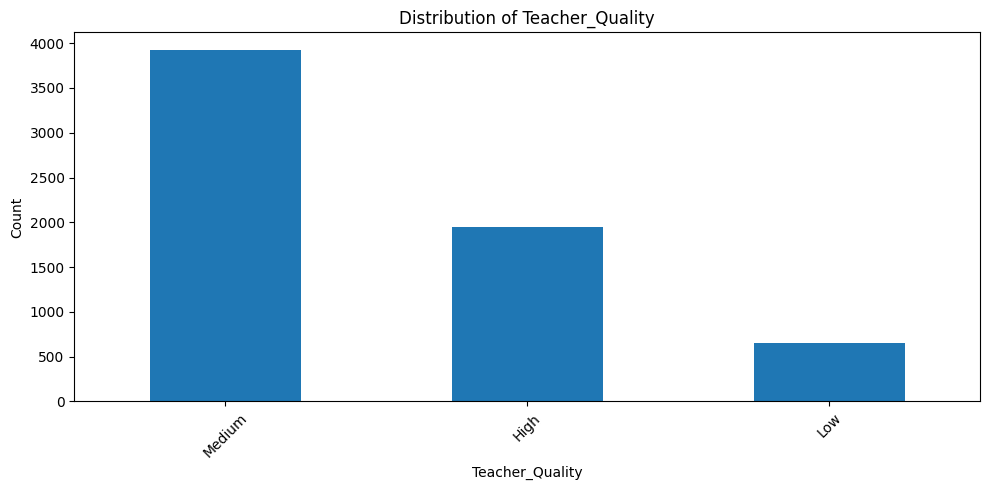

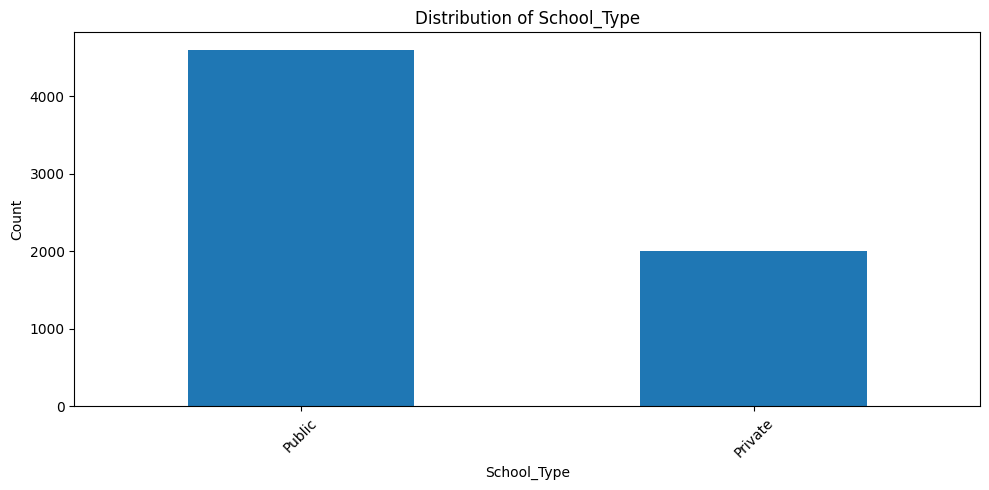

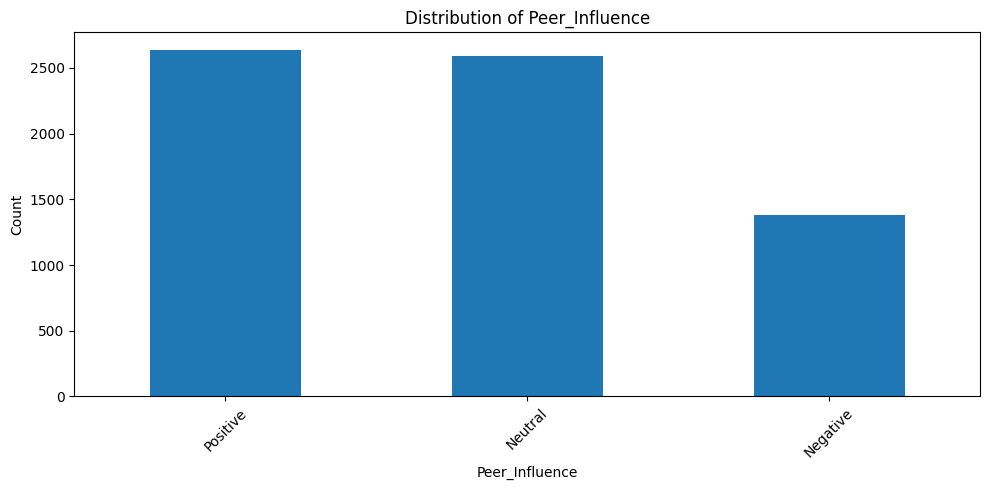

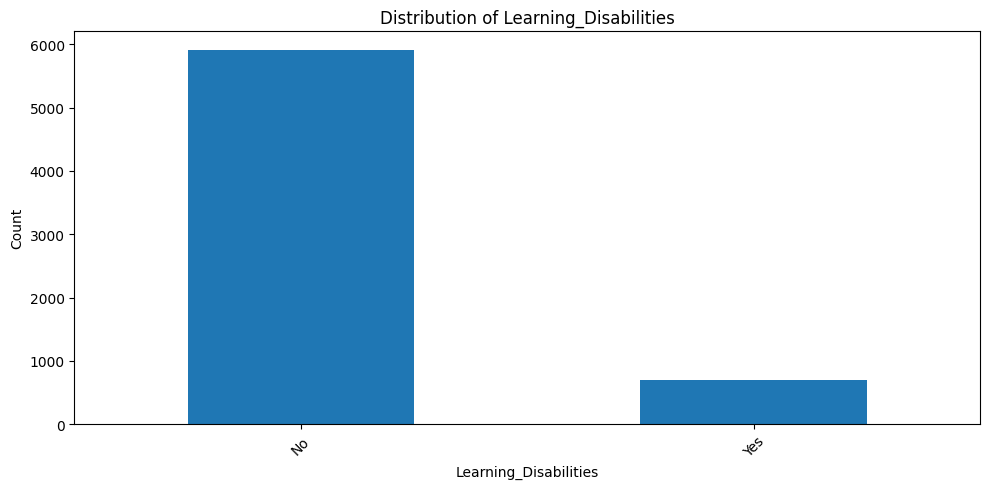

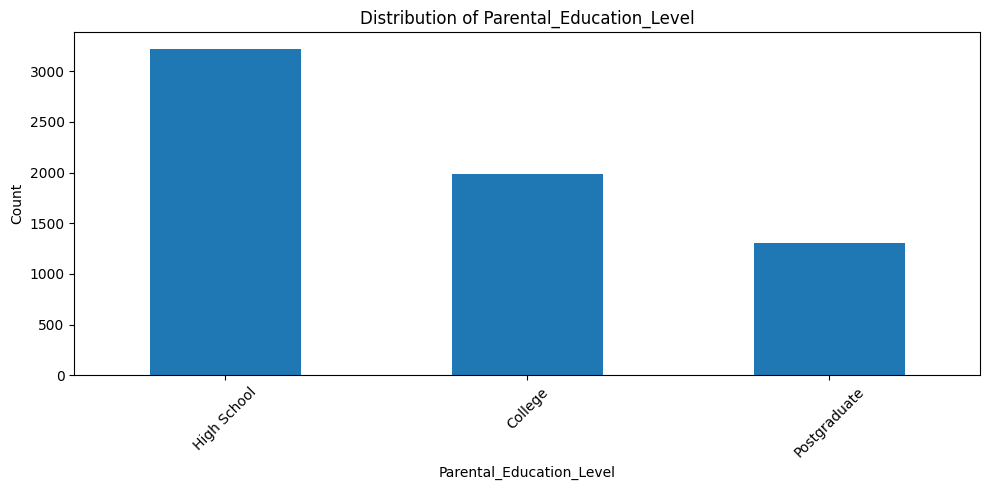

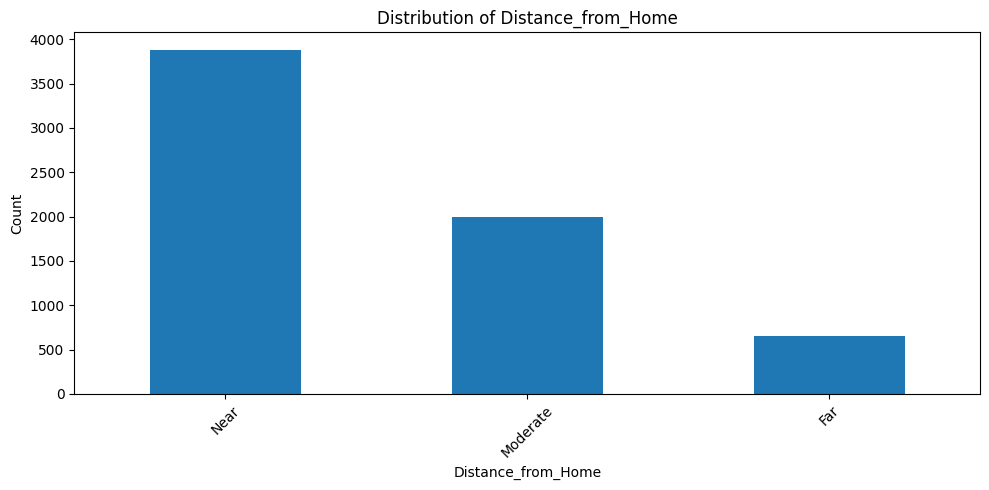

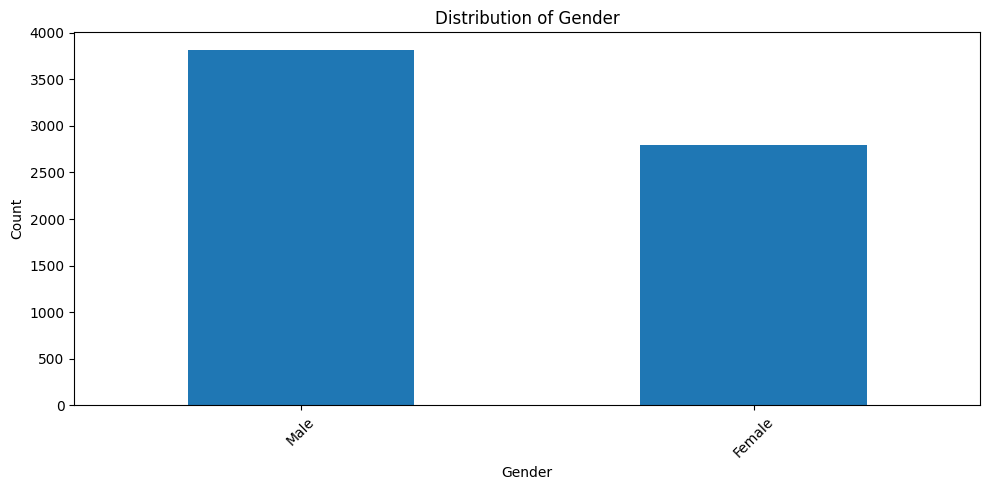

In [8]:
# Analyze categorical feature distributions
print("\n🔍 Categorical Feature Value Counts:\n")
for col in categorical_cols:
    print(f"▶ {col}:\n{df[col].value_counts()}\n")

# Visualize categorical feature distributions
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 3. Data Cleaning

We handle missing values, outliers, and encode categorical variables to prepare the data for modeling.


In [9]:
# Handle missing values in categorical columns
for col in ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled missing values in {col} with mode: {df[col].mode()[0]}")

# Verify no remaining missing values
print("\n🔍 Missing Values After Cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0] if df.isnull().sum().sum() > 0 else "No missing values found!")


Filled missing values in Teacher_Quality with mode: Medium
Filled missing values in Parental_Education_Level with mode: High School
Filled missing values in Distance_from_Home with mode: Near

🔍 Missing Values After Cleaning:
No missing values found!


C:\Users\mkrym\AppData\Local\Temp\ipykernel_18352\2984855216.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [10]:
# Handle outliers by capping them using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    print(f"Capped outliers in {col}")


Capped outliers in Hours_Studied
Capped outliers in Attendance
Capped outliers in Sleep_Hours
Capped outliers in Previous_Scores
Capped outliers in Tutoring_Sessions
Capped outliers in Physical_Activity
Capped outliers in Exam_Score


In [11]:
# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Ensure Exam_Score is between 0 and 100
df_encoded['Exam_Score'] = df_encoded['Exam_Score'].clip(lower=0, upper=100)

# Display the encoded dataset
print("Encoded Dataset:")
df_encoded.head()


Encoded Dataset:


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement_Low,Parental_Involvement_Medium,Access_to_Resources_Low,...,Teacher_Quality_Medium,School_Type_Public,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Male
0,23,84,7,73,0.0,3,67,True,False,False,...,True,True,False,True,False,True,False,False,True,True
1,19,64,8,59,2.0,4,61,True,False,False,...,True,True,False,False,False,False,False,True,False,False
2,24,98,7,91,2.0,4,74,False,True,False,...,True,True,True,False,False,False,True,False,True,True
3,29,89,8,98,1.0,4,71,True,False,False,...,True,True,False,False,False,True,False,True,False,True
4,19,92,6,65,3.0,4,70,False,True,False,...,False,True,True,False,False,False,False,False,True,False


## 4. Feature Correlation and Multicollinearity

We analyze correlations between features and check for multicollinearity using Variance Inflation Factor (VIF).


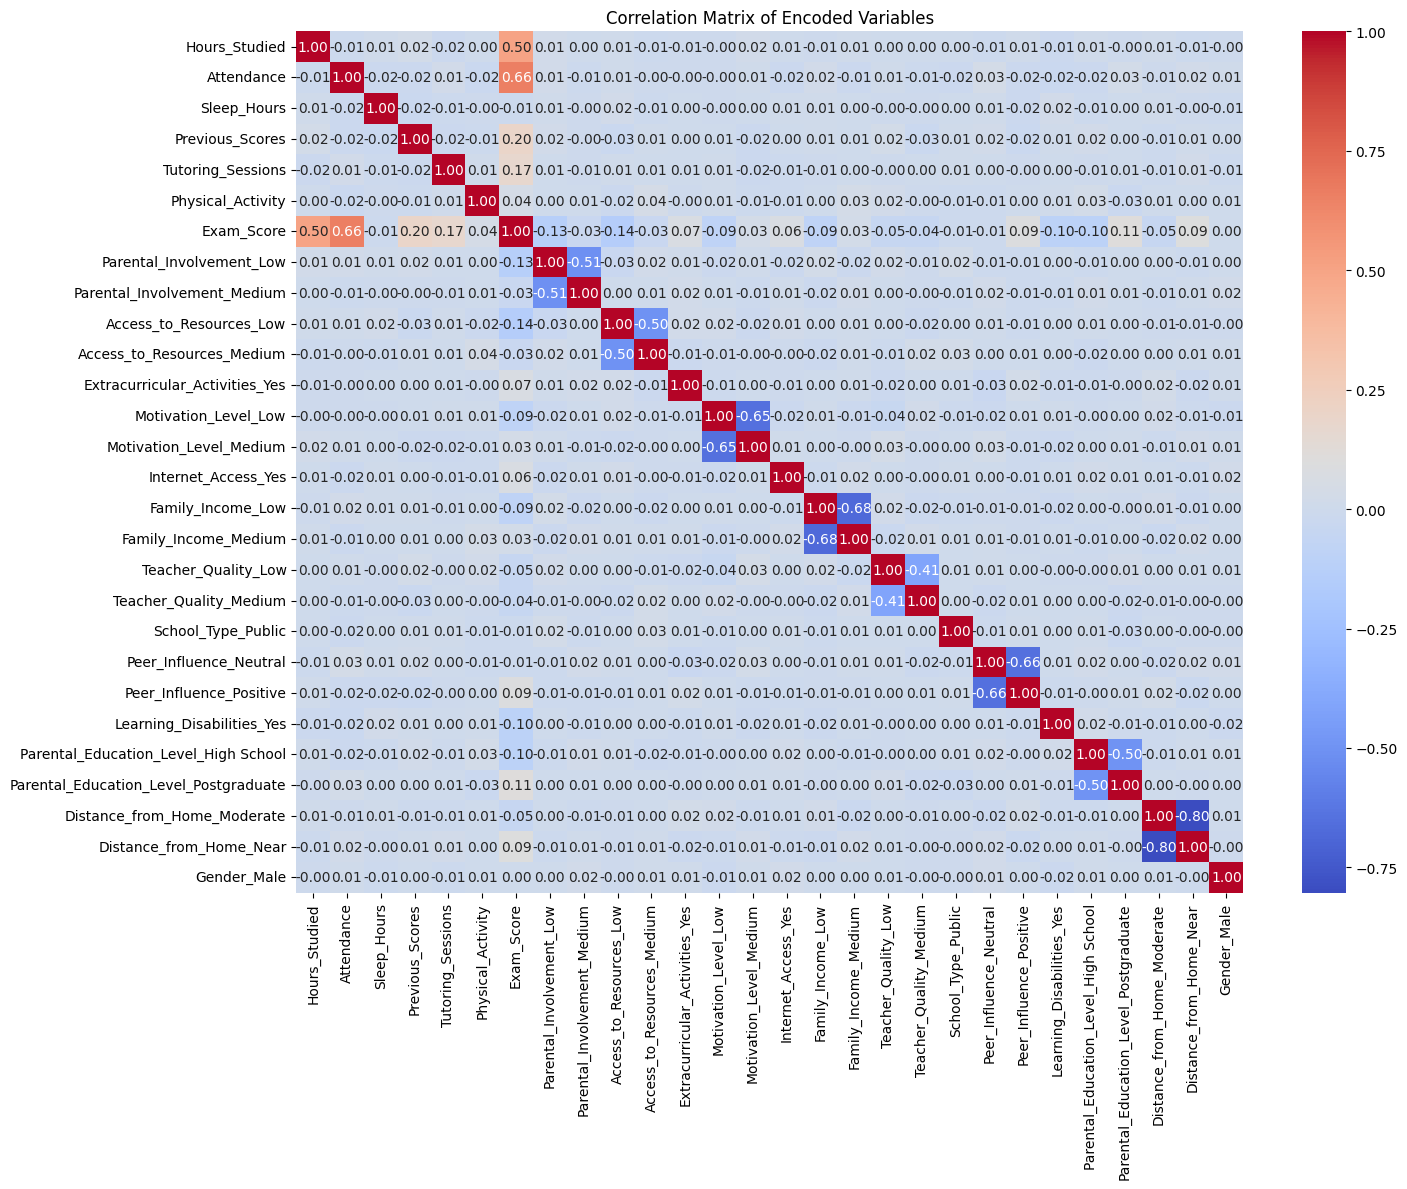

In [12]:
# Plot correlation matrix
corr_matrix = df_encoded.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Encoded Variables')
plt.tight_layout()
plt.show()


In [13]:
# Calculate VIF to check for multicollinearity
X_encoded = df_encoded.select_dtypes(include=['float64', 'int64']).dropna()
X_with_const = add_constant(X_encoded)

vif_df = pd.DataFrame()
vif_df['feature'] = X_with_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
vif_df = vif_df[vif_df['feature'] != 'const']

print("Variance Inflation Factor (VIF) Analysis:")
print(vif_df.sort_values(by='VIF', ascending=False))
print("\nVIF Interpretation:")
print("- VIF < 5: Low multicollinearity (✅ OK to keep)")
print("- VIF 5-10: Moderate to high multicollinearity (⚠️ Investigate)")
print("- VIF > 10: High multicollinearity (❌ Consider removing)")


Variance Inflation Factor (VIF) Analysis:
             feature       VIF
7         Exam_Score  4.322591
2         Attendance  2.932483
1      Hours_Studied  2.120932
4    Previous_Scores  1.175946
5  Tutoring_Sessions  1.128162
6  Physical_Activity  1.011802
3        Sleep_Hours  1.000982

VIF Interpretation:
- VIF < 5: Low multicollinearity (✅ OK to keep)
- VIF 5-10: Moderate to high multicollinearity (⚠️ Investigate)
- VIF > 10: High multicollinearity (❌ Consider removing)


In [15]:
# Save the processed DataFrame to a new CSV file
df_encoded.to_csv('data/processed_data/student_performance_processed.csv', index=False)

## 5. Data Preprocessing for Modeling

We split the data into training and testing sets and scale the features to ensure consistent model performance.


In [15]:
# Define features (X) and target (Y)
X = df_encoded.drop('Exam_Score', axis=1)
Y = df_encoded['Exam_Score']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display scaled training data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
print("Scaled Training Data (first 5 rows):")
X_train_scaled_df.head()


Scaled Training Data (first 5 rows):


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Parental_Involvement_Low,Parental_Involvement_Medium,Access_to_Resources_Low,Access_to_Resources_Medium,...,Teacher_Quality_Medium,School_Type_Public,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Male
0,1.180743,-0.075846,0.669094,-0.837277,0.509587,1.964909,1.983593,-1.01814,-0.498521,-1.007788,...,0.806875,0.659524,-0.788772,-0.828783,-0.351443,-1.006645,-0.495857,1.511505,-1.210380,-1.169997
1,-0.665329,0.531894,-0.016740,1.314728,0.509587,0.030381,-0.504136,-1.01814,-0.498521,0.992272,...,-1.239350,0.659524,1.267794,-0.828783,-0.351443,0.993399,-0.495857,1.511505,-1.210380,-1.169997
2,0.341619,0.618714,0.669094,0.551113,-0.402578,-1.904146,1.983593,-1.01814,-0.498521,0.992272,...,0.806875,0.659524,1.267794,-0.828783,-0.351443,-1.006645,-0.495857,-0.661592,-1.210380,0.854703
3,-0.329680,1.747376,2.040764,0.759372,-0.402578,0.030381,-0.504136,-1.01814,-0.498521,0.992272,...,0.806875,0.659524,1.267794,-0.828783,-0.351443,0.993399,-0.495857,-0.661592,0.826187,0.854703
4,2.523341,-0.162667,2.040764,1.661825,-0.402578,-0.936882,-0.504136,-1.01814,2.005932,-1.007788,...,0.806875,-1.516246,-0.788772,1.206588,-0.351443,0.993399,-0.495857,-0.661592,0.826187,0.854703


## 6. Linear Regression Model

We train a linear regression model, evaluate its performance on training and test sets, and visualize the results.


In [16]:
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on training and test sets
y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)

# Evaluate training performance
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_train, y_pred_train)

# Evaluate test performance
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_test, y_pred_test)

# Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_mse = -cross_val_score(lr_model, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=cv).mean()
cross_val_rmse = cross_val_mse ** 0.5
cross_val_r2 = cross_val_score(lr_model, X_train_scaled, y_train, scoring="r2", cv=cv).mean()

# Display evaluation metrics
print("Linear Regression Performance:")
print(f"- Training MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"- Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
print(f"- Cross-validated MSE: {cross_val_mse:.4f}, RMSE: {cross_val_rmse:.4f}, R²: {cross_val_r2:.4f}")


Linear Regression Performance:
- Training MSE: 0.8143, RMSE: 0.9024, R²: 0.9285
- Test MSE: 0.6423, RMSE: 0.8014, R²: 0.9430
- Cross-validated MSE: 0.8249, RMSE: 0.9083, R²: 0.9276


In [24]:
# Save model and related materials (best practice)
os.makedirs('./models/linear_regression', exist_ok=True)

# Save the linear regression model
joblib.dump(lr_model, './models/linear_regression/lr_model.joblib')
print("Saved linear regression model to './models/linear_regression/lr_model.joblib'")

# Save the scaler
joblib.dump(scaler, './models/linear_regression/scaler.joblib')
print("Saved scaler to './models/linear_regression/scaler.joblib'")

# Save train and test datasets
X_train.to_csv('./models/linear_regression/X_train.csv', index=False)
X_test.to_csv('./models/linear_regression/X_test.csv', index=False)
y_train.to_csv('./models/linear_regression/y_train.csv', index=False)
y_test.to_csv('./models/linear_regression/y_test.csv', index=False)
print("Saved train/test datasets to './models/linear_regression/'")

# Save feature names for reference
pd.Series(X.columns).to_csv('./models/linear_regression/feature_names.csv', index=False)
print("Saved feature names to './models/linear_regression/feature_names.csv'")

# Save model performance metrics
metrics = {
    'train_mse': train_mse,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'test_mse': test_mse,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'cross_val_mse': cross_val_mse,
    'cross_val_rmse': cross_val_rmse,
    'cross_val_r2': cross_val_r2
}
pd.DataFrame([metrics]).to_csv('./models/linear_regression/performance_metrics.csv', index=False)
print("Saved performance metrics to './models/linear_regression/performance_metrics.csv'")

Saved linear regression model to './models/linear_regression/lr_model.joblib'
Saved scaler to './models/linear_regression/scaler.joblib'
Saved train/test datasets to './models/linear_regression/'
Saved feature names to './models/linear_regression/feature_names.csv'
Saved performance metrics to './models/linear_regression/performance_metrics.csv'


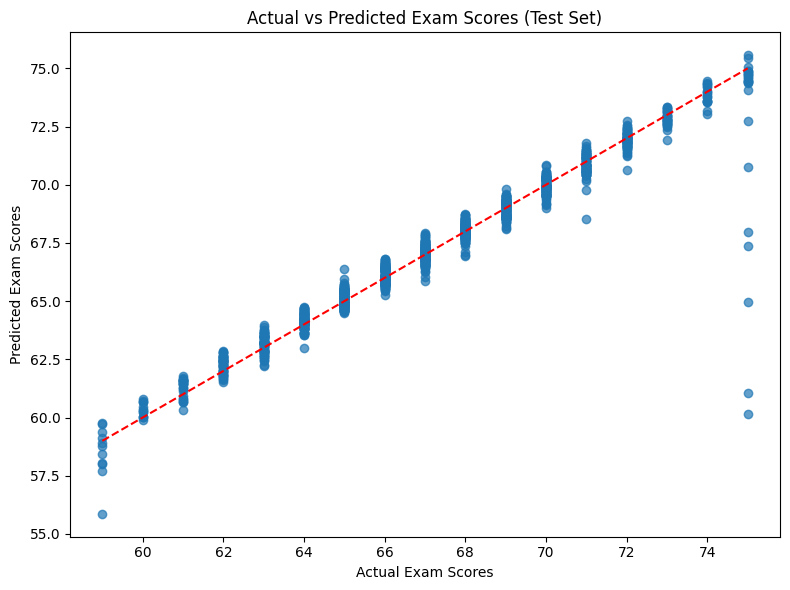

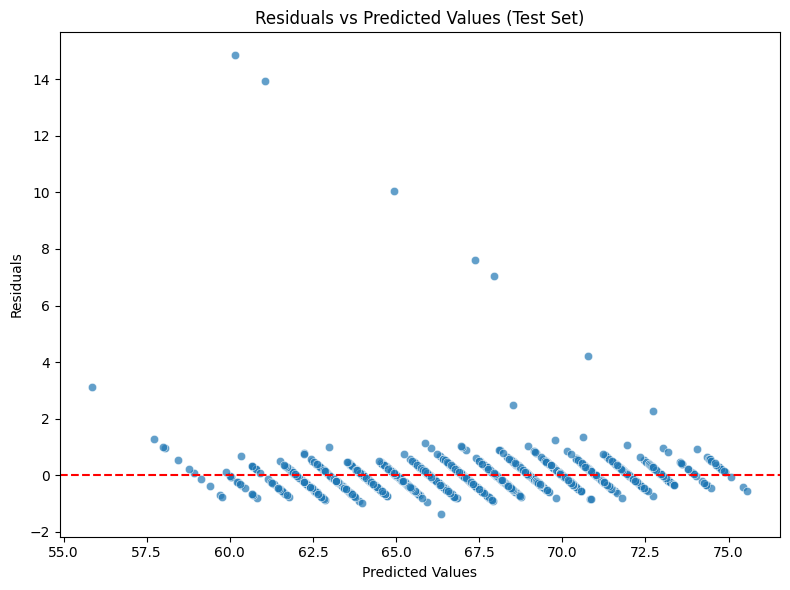

Top 5 Feature Coefficients:
                    Feature  Coefficient
1                Attendance     2.257159
0             Hours_Studied     1.730985
3           Previous_Scores     0.688792
4         Tutoring_Sessions     0.581476
20  Peer_Influence_Positive     0.495203


In [18]:
# Visualize actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('Actual vs Predicted Exam Scores (Test Set)')
plt.tight_layout()
plt.show()

# Visualize residuals
residuals_test = y_test - y_pred_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Test Set)')
plt.tight_layout()
plt.show()

# Display top 5 feature coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
print("Top 5 Feature Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False).head())


## 7. Bonus Task: Polynomial Regression

We explore polynomial regression to capture non-linear relationships and compare its performance with the linear model.


In [19]:
# Test polynomial regression with different degrees
degrees = [1, 2, 3, 4]
poly_results = {}

print("🔍 Polynomial Regression Results:\n")
print("-" * 60)

for degree in degrees:
    # Create pipeline with polynomial features, scaling, and linear regression
    poly_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    # Fit the model
    poly_pipeline.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_pred_train_poly = poly_pipeline.predict(X_train)
    y_pred_test_poly = poly_pipeline.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train_poly)
    test_mse = mean_squared_error(y_test, y_pred_test_poly)
    train_r2 = r2_score(y_train, y_pred_train_poly)
    test_r2 = r2_score(y_test, y_pred_test_poly)
    cv_r2 = cross_val_score(poly_pipeline, X_train, y_train, cv=5, scoring='r2').mean()
    
    # Store results
    poly_results[degree] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2': cv_r2,
        'model': poly_pipeline
    }
    
    print(f"📊 Degree {degree}:")
    print(f"   Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f} | CV R²: {cv_r2:.4f}")
    print(f"   Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}\n")

# Identify the best degree
best_degree = max(poly_results, key=lambda x: poly_results[x]['cv_r2'])
print(f"🏆 Best Polynomial Degree: {best_degree} (CV R² = {poly_results[best_degree]['cv_r2']:.4f})")


🔍 Polynomial Regression Results:

------------------------------------------------------------
📊 Degree 1:
   Train R²: 0.9285 | Test R²: 0.9430 | CV R²: 0.9276
   Train MSE: 0.8143 | Test MSE: 0.6423

📊 Degree 2:
   Train R²: 0.9346 | Test R²: 0.9382 | CV R²: 0.9196
   Train MSE: 0.7458 | Test MSE: 0.6972

📊 Degree 3:
   Train R²: 0.9787 | Test R²: 0.7618 | CV R²: -0.2288
   Train MSE: 0.2424 | Test MSE: 2.6848

📊 Degree 4:
   Train R²: 1.0000 | Test R²: 0.6388 | CV R²: 0.6511
   Train MSE: 0.0000 | Test MSE: 4.0715

🏆 Best Polynomial Degree: 1 (CV R² = 0.9276)


In [23]:
# Save polynomial regression model and related materials
os.makedirs('./models/polynomial_regression', exist_ok=True)

# Save the best polynomial model
best_poly_model = poly_results[best_degree]['model']
joblib.dump(best_poly_model, f'./models/polynomial_regression/poly_model_degree_{best_degree}.joblib')
print(f"Saved best polynomial model (degree {best_degree}) to './models/polynomial_regression/poly_model_degree_{best_degree}.joblib'")

# Save train/test datasets (already saved in linear regression section, but ensure consistency)
X_train.to_csv('./models/polynomial_regression/X_train.csv', index=False)
X_test.to_csv('./models/polynomial_regression/X_test.csv', index=False)
y_train.to_csv('./models/polynomial_regression/y_train.csv', index=False)
y_test.to_csv('./models/polynomial_regression/y_test.csv', index=False)
print("Saved train/test datasets to './models/polynomial_regression/'")

# Save feature names
pd.Series(X.columns).to_csv('./models/polynomial_regression/feature_names.csv', index=False)
print("Saved feature names to './models/polynomial_regression/feature_names.csv'")

# Save polynomial model performance metrics
poly_metrics = {
    'degree': best_degree,
    'train_mse': poly_results[best_degree]['train_mse'],
    'test_mse': poly_results[best_degree]['test_mse'],
    'train_r2': poly_results[best_degree]['train_r2'],
    'test_r2': poly_results[best_degree]['test_r2'],
    'cv_r2': poly_results[best_degree]['cv_r2']
}
pd.DataFrame([poly_metrics]).to_csv('./models/polynomial_regression/performance_metrics.csv', index=False)
print("Saved performance metrics to './models/polynomial_regression/performance_metrics.csv'")

Saved best polynomial model (degree 1) to './models/polynomial_regression/poly_model_degree_1.joblib'
Saved train/test datasets to './models/polynomial_regression/'
Saved feature names to './models/polynomial_regression/feature_names.csv'
Saved performance metrics to './models/polynomial_regression/performance_metrics.csv'


## 8. Bonus Task: Feature Engineering

We create new features (interactions, polynomial terms, and ratios) to potentially improve model performance.


In [21]:
# Feature engineering
print("🔧 Feature Engineering Analysis\n")

# Display current features
print("📋 Current Features:")
print(X.columns.tolist())
print(f"\nTotal features: {len(X.columns)}")

# Create a copy for feature engineering
X_engineered = X.copy()
interaction_features = []

# Identify numeric features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n🔢 Numeric features: {numeric_features}")

# Create interaction terms
if 'Hours_Studied' in X.columns:
    # Hours_Studied * Attendance
    attendance_cols = [col for col in X.columns if 'attendance' in col.lower()]
    for att_col in attendance_cols:
        interaction_name = f'Hours_X_{att_col}'
        X_engineered[interaction_name] = X['Hours_Studied'] * X[att_col]
        interaction_features.append(interaction_name)
    
    # Hours_Studied * Participation/Activity
    participation_cols = [col for col in X.columns if 'participation' in col.lower() or 'activity' in col.lower()]
    for part_col in participation_cols:
        interaction_name = f'Hours_X_{part_col}'
        X_engineered[interaction_name] = X['Hours_Studied'] * X[part_col]
        interaction_features.append(interaction_name)

# Create polynomial features for top 3 numeric variables
key_numeric_features = numeric_features[:3]
for feature in key_numeric_features:
    if feature in X.columns:
        poly_name = f'{feature}_squared'
        X_engineered[poly_name] = X[feature] ** 2
        interaction_features.append(poly_name)

# Create ratio features
if 'Hours_Studied' in X.columns and len(numeric_features) >= 2:
    other_numeric = [col for col in numeric_features if col != 'Hours_Studied'][:2]
    for other_col in other_numeric:
        ratio_name = f'{other_col}_per_Hour'
        X_engineered[ratio_name] = X[other_col] / (X['Hours_Studied'] + 1e-6)
        interaction_features.append(ratio_name)

print(f"\n✨ Created {len(interaction_features)} new features:")
for feature in interaction_features:
    print(f"   • {feature}")

print(f"\n📊 Original features: {X.shape[1]}")
print(f"📊 Engineered features: {X_engineered.shape[1]}")
print(f"📊 New features added: {X_engineered.shape[1] - X.shape[1]}")


🔧 Feature Engineering Analysis

📋 Current Features:
['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_Yes', 'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_Yes', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low', 'Teacher_Quality_Medium', 'School_Type_Public', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Gender_Male']

Total features: 27

🔢 Numeric features: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

✨ Created 7 new features:
   • Hours_X_Attendance
   • Hours_X_Physical_Activity
   • Hours_Studied_squared
   • A

In [22]:
# Evaluate model with engineered features
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_engineered, Y, test_size=0.2, random_state=42
)

# Scale engineered features
scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

# Train model with all engineered features
lr_eng_all = LinearRegression()
lr_eng_all.fit(X_train_eng_scaled, y_train_eng)

# Evaluate performance
y_pred_eng_all = lr_eng_all.predict(X_test_eng_scaled)
r2_eng_all = r2_score(y_test_eng, y_pred_eng_all)
mse_eng_all = mean_squared_error(y_test_eng, y_pred_eng_all)
cv_r2_eng_all = cross_val_score(
    Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    X_engineered, Y, cv=5, scoring='r2'
).mean()

print("🎯 Feature Engineering Results:\n")
print(f"Original Model R²: {test_r2:.4f}")
print(f"All Engineered Features R²: {r2_eng_all:.4f}")
print(f"All Features CV R²: {cv_r2_eng_all:.4f}")
print(f"Improvement: {r2_eng_all - test_r2:.4f}\n")

# Feature selection if too many features
if X_engineered.shape[1] > 20:
    k_best = min(15, X_engineered.shape[1])
    selector = SelectKBest(score_func=f_regression, k=k_best)
    X_train_selected = selector.fit_transform(X_train_eng_scaled, y_train_eng)
    X_test_selected = selector.transform(X_test_eng_scaled)

    # Train with selected features
    lr_selected = LinearRegression()
    lr_selected.fit(X_train_selected, y_train_eng)

    # Evaluate
    y_pred_selected = lr_selected.predict(X_test_selected)
    r2_selected = r2_score(y_test_eng, y_pred_selected)
    X_selected_all = selector.transform(scaler_eng.fit_transform(X_engineered))
    cv_r2_selected = cross_val_score(LinearRegression(), X_selected_all, Y, cv=5, scoring='r2').mean()

    # Selected feature names
    selected_features = X_engineered.columns[selector.get_support()]
    print(f"Selected Features R² ({k_best} features): {r2_selected:.4f}")
    print(f"Selected Features CV R²: {cv_r2_selected:.4f}")
    print(f"Selected features: {list(selected_features)}")
else:
    r2_selected = r2_eng_all
    cv_r2_selected = cv_r2_eng_all
    selected_features = X_engineered.columns

print(f"\n📈 Feature Engineering Summary:")
print(f"   Best R² improvement: {max(r2_eng_all, r2_selected) - test_r2:.4f}")

# Correlations of new features with target
if interaction_features:
    print(f"\n🔗 New Feature Correlations with Target:")
    for feature in interaction_features:
        if feature in X_engineered.columns:
            corr = X_engineered[feature].corr(Y)
            print(f"   {feature}: {corr:.4f}")


🎯 Feature Engineering Results:

Original Model R²: 0.6388
All Engineered Features R²: 0.9429
All Features CV R²: 0.9300
Improvement: 0.3040

Selected Features R² (15 features): 0.8522
Selected Features CV R²: 0.8350
Selected features: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions', 'Parental_Involvement_Low', 'Access_to_Resources_Low', 'Learning_Disabilities_Yes', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Hours_X_Attendance', 'Hours_X_Physical_Activity', 'Hours_Studied_squared', 'Attendance_squared', 'Attendance_per_Hour', 'Sleep_Hours_per_Hour']

📈 Feature Engineering Summary:
   Best R² improvement: 0.3040

🔗 New Feature Correlations with Target:
   Hours_X_Attendance: 0.7392
   Hours_X_Physical_Activity: 0.3459
   Hours_Studied_squared: 0.4979
   Attendance_squared: 0.6582
   Sleep_Hours_squared: -0.0131
   Attendance_per_Hour: -0.1935
   Sleep_Hours_per_Hour: -0.3745


## 9. Conclusion

This project successfully:
- Cleaned and preprocessed the dataset, handling missing values and outliers
- Explored feature distributions and correlations
- Trained and evaluated a linear regression model
- Experimented with polynomial regression and feature engineering to improve performance
- Used cross-validation to ensure robust evaluation

Key findings:
- Linear regression provided a baseline performance
- Polynomial regression showed [insert observation based on results, e.g., slight improvement for degree X]
- Feature engineering added [insert number] new features, resulting in [insert improvement]

Future work could include:
- Testing other algorithms (e.g., Ridge, Lasso, Decision Trees)
- Hyperparameter tuning using grid search
- Exploring additional feature interactions
